## 1. Introduction
This notebook aims to examine the lead score assigned to each lead. The goal is to learn the `patterns of leads in different score groups` so that certain plans and actions can be executed for certain business goals.

In [28]:
import joblib
import pandas as pd
from scipy.sparse import issparse

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## 2. Load Models and Preprocessor

In [29]:
model_filename = 'models/xgb_lead_scoring_model.joblib'
preprocessor_filename = 'preprocessor/lead_scoring_preprocessor.joblib'
feature_names_filename = 'models/lead_scoring_feature_names.joblib'

xgb_model = joblib.load(model_filename)
preprocessor = joblib.load(preprocessor_filename)
feature_names = joblib.load(feature_names_filename)

print(f"Model loaded from: {model_filename}")
print(f"Preprocessor loaded from: {preprocessor_filename}")
print(f"Feature names loaded from: {feature_names_filename}")

Model loaded from: models/xgb_lead_scoring_model.joblib
Preprocessor loaded from: preprocessor/lead_scoring_preprocessor.joblib
Feature names loaded from: models/lead_scoring_feature_names.joblib


In [30]:
feature_names

array(['pipeline-1__Lead Origin_API',
       'pipeline-1__Lead Origin_Landing Page Submission',
       'pipeline-1__Lead Origin_Lead Add Form',
       'pipeline-1__Lead Origin_Lead Import',
       'pipeline-1__Lead Origin_Quick Add Form',
       'pipeline-1__Lead Source_Direct Traffic',
       'pipeline-1__Lead Source_Facebook',
       'pipeline-1__Lead Source_Google',
       'pipeline-1__Lead Source_Olark Chat',
       'pipeline-1__Lead Source_Organic Search',
       'pipeline-1__Lead Source_Other',
       'pipeline-1__Lead Source_Reference',
       'pipeline-1__Lead Source_Referral Sites',
       'pipeline-1__Lead Source_Welingak Website',
       'pipeline-1__Do Not Email_0', 'pipeline-1__Do Not Email_1',
       'pipeline-1__Last Activity_Converted to Lead',
       'pipeline-1__Last Activity_Email Link Clicked',
       'pipeline-1__Last Activity_Email Opened',
       'pipeline-1__Last Activity_Not Interested in Email',
       'pipeline-1__Last Activity_Olark Chat Conversation',
     

## 3. Load Data
The goal is to study the `Lead Score` by the model so the whole data will be used.

In [31]:
df = pd.read_csv('data/lead_scoring.csv')

In [32]:
df.drop(columns = ['Converted'], inplace = True)

## 4. Calculate `Lead Score`

In [33]:
df_transformed = preprocessor.transform(df)

In [34]:
lead_scores = xgb_model.predict_proba(df_transformed)[:, 1] * 100

In [35]:
for i, score in enumerate(lead_scores):
    print(f"  Lead {i+1}: {score:.2f}")

  Lead 1: 0.21
  Lead 2: 38.45
  Lead 3: 60.29
  Lead 4: 4.56
  Lead 5: 65.20
  Lead 6: 0.81
  Lead 7: 72.33
  Lead 8: 0.81
  Lead 9: 1.61
  Lead 10: 1.07
  Lead 11: 92.70
  Lead 12: 53.97
  Lead 13: 93.68
  Lead 14: 3.17
  Lead 15: 8.26
  Lead 16: 69.71
  Lead 17: 0.81
  Lead 18: 26.48
  Lead 19: 90.64
  Lead 20: 2.16
  Lead 21: 8.57
  Lead 22: 3.70
  Lead 23: 75.07
  Lead 24: 52.32
  Lead 25: 92.94
  Lead 26: 71.54
  Lead 27: 76.24
  Lead 28: 73.19
  Lead 29: 0.22
  Lead 30: 55.11
  Lead 31: 81.00
  Lead 32: 3.15
  Lead 33: 1.06
  Lead 34: 0.32
  Lead 35: 51.12
  Lead 36: 73.61
  Lead 37: 49.74
  Lead 38: 98.53
  Lead 39: 3.63
  Lead 40: 2.50
  Lead 41: 7.80
  Lead 42: 1.36
  Lead 43: 3.64
  Lead 44: 0.74
  Lead 45: 6.57
  Lead 46: 11.69
  Lead 47: 17.04
  Lead 48: 0.81
  Lead 49: 27.15
  Lead 50: 0.81
  Lead 51: 38.92
  Lead 52: 6.71
  Lead 53: 6.36
  Lead 54: 0.93
  Lead 55: 0.57
  Lead 56: 5.16
  Lead 57: 65.96
  Lead 58: 85.84
  Lead 59: 4.81
  Lead 60: 34.90
  Lead 61: 2.73
  Le

In [9]:
# Add the lead score to the data
df['Lead Score'] = lead_scores

In [10]:
# Create lead type categories based on scores
df['Lead Type'] = pd.cut(df['Lead Score'], 
                        bins=[-float('inf'), 30, 70, float('inf')],
                        labels=['Cold', 'Warm', 'Hot'])

# Display distribution of lead types
print("\nLead Type Distribution:")
print(df['Lead Type'].value_counts())



Lead Type Distribution:
Lead Type
Cold    4910
Hot     2637
Warm    1693
Name: count, dtype: int64


## 5. Analysis
As we already know which features are focused on during training 

In [11]:
hot_df = df[df['Lead Type'] == 'Hot']
warm_df = df[df['Lead Type'] == 'Warm']
cold_df = df[df['Lead Type'] == 'Cold']
cold_df.to_csv('data/cold_df.csv', index = False)

In [12]:
# Define color map for lead types
lead_type_colors = {
    'Cold': '#89CFF0',  # Medium blue
    'Hot': '#FFa0aB',   # Medium pink  
    'Warm': '#FFE5B4'   # Medium yellow
}

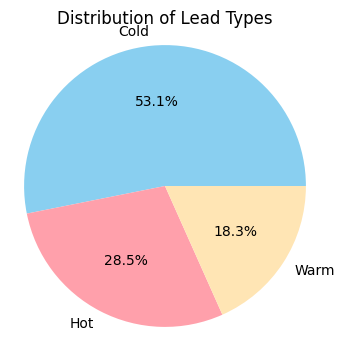

In [13]:

# Create a pie chart showing distribution of lead types
plt.figure(figsize=(4, 4))
plt.pie(df['Lead Type'].value_counts(),
        labels=df['Lead Type'].value_counts().index,
        autopct='%1.1f%%',
        colors=[lead_type_colors[t] for t in df['Lead Type'].value_counts().index])
plt.title('Distribution of Lead Types')
plt.axis('equal')
plt.show()


### Utils

In [14]:
def plot_categorical_distribution(data, column, title=None, figsize=(12,6)):
    """
    Creates a grouped bar plot showing the distribution of categorical values across lead types using seaborn's hue
    
    Parameters:
    -----------
    data : DataFrame
        The dataframe containing the data
    column : str
        The categorical column to analyze
    title : str, optional
        Title for the plot
    figsize : tuple, optional
        Figure size as (width, height)
    """
    # Create plot data
    plot_data = data.groupby(['Lead Type', column]).size().reset_index(name='Count')
    
    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(data=plot_data, x=column, y='Count', hue='Lead Type', 
                palette=lead_type_colors)
    
    # Customize the plot
    if title:
        plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


In [21]:
def plot_numerical_distribution(data, column, title=None, figsize=(12,6)):
    """
    Creates a box plot showing the distribution of numerical values across lead types
    
    Parameters:
    -----------
    data : DataFrame
        The dataframe containing the data
    column : str
        The numerical column to analyze
    title : str, optional
        Title for the plot
    figsize : tuple, optional
        Figure size as (width, height)
    """
    # Create the plot
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, x='Lead Type', y=column, palette=lead_type_colors)
    
    # Customize the plot
    if title:
        plt.title(title)
    plt.xlabel('Lead Type')
    plt.ylabel(column)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


### 5.1. `Lead Origin`

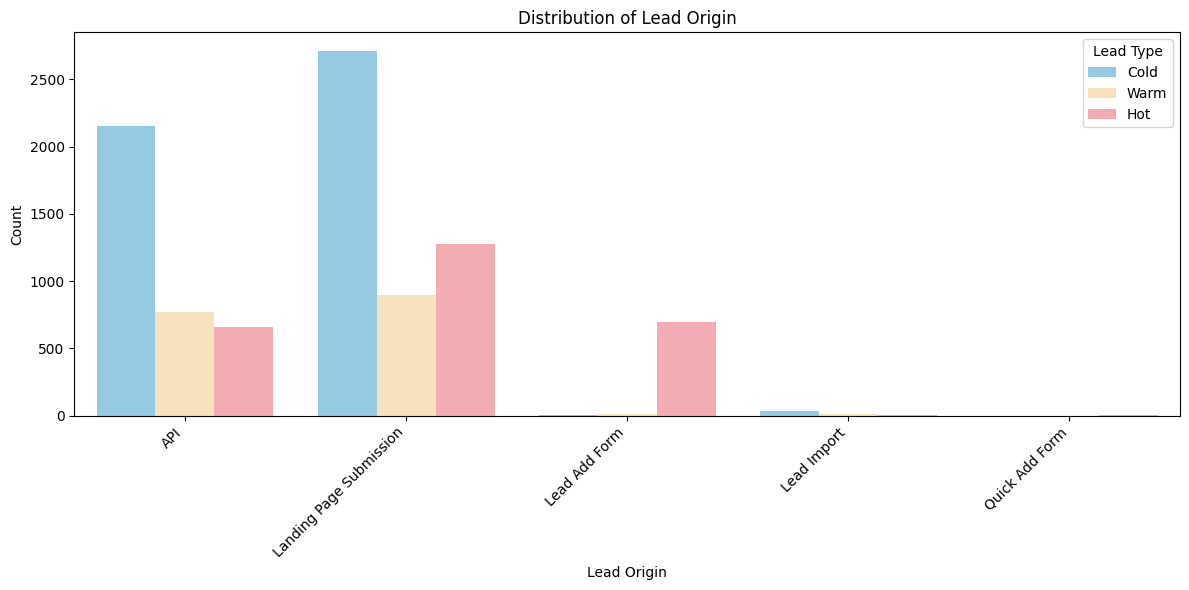

In [15]:
plot_categorical_distribution(df, column = 'Lead Origin', title = 'Distribution of Lead Origin')

### 5.2. `Lead Source`

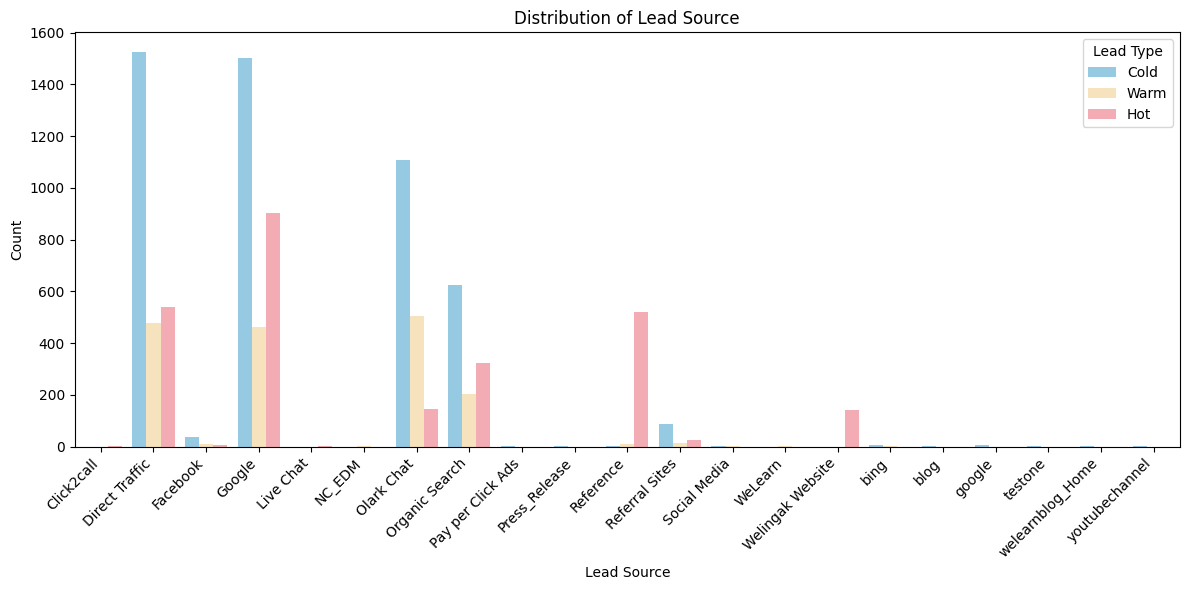

In [16]:
plot_categorical_distribution(df, column = 'Lead Source', title = 'Distribution of Lead Source')

### 5.3. `Last Activity`

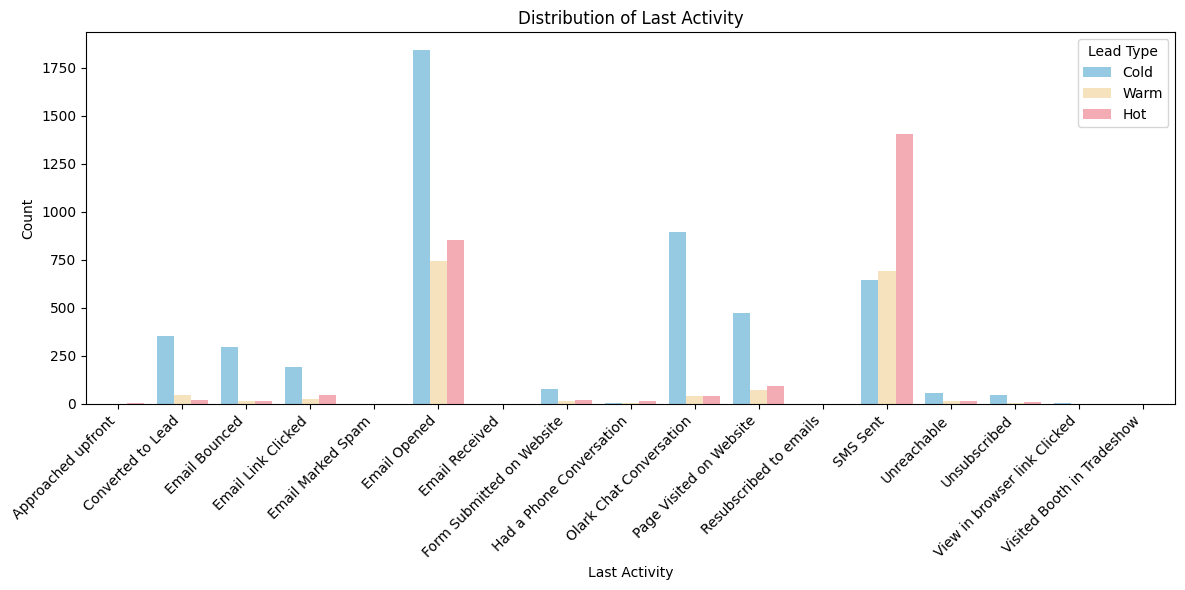

In [17]:
plot_categorical_distribution(df, column = 'Last Activity', title = 'Distribution of Last Activity')

### 5.4. `Specialization`

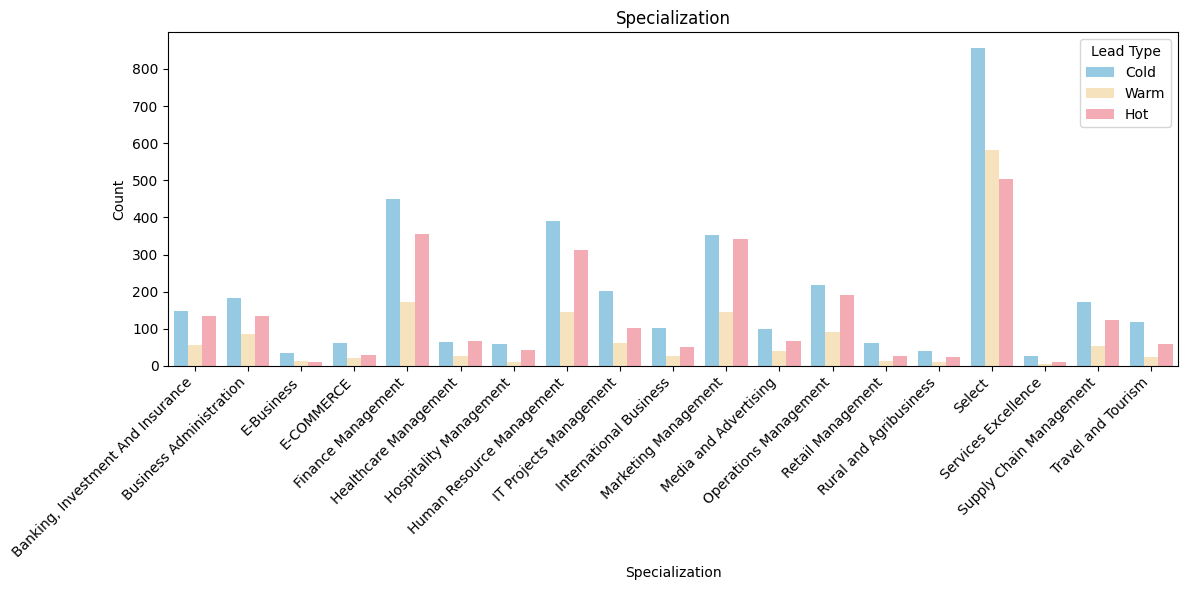

In [18]:
plot_categorical_distribution(df, column = 'Specialization', title = 'Specialization')

### 5.5. `Occupation`

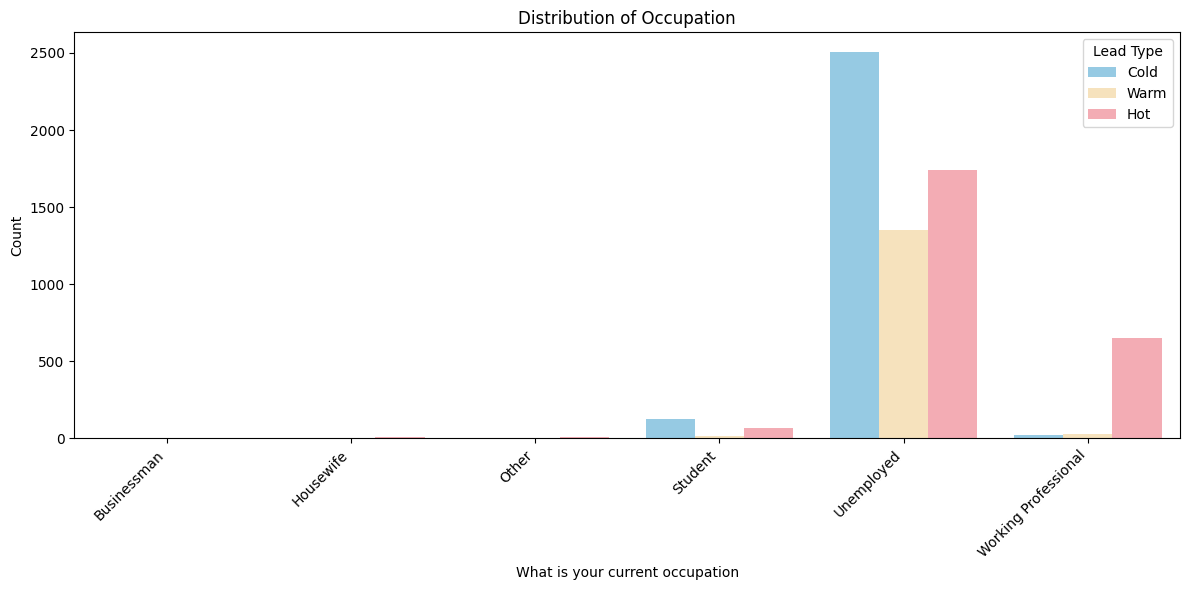

In [19]:
plot_categorical_distribution(df, column = 'What is your current occupation', title = 'Distribution of Occupation')

### 5.6. `Do Not Email`

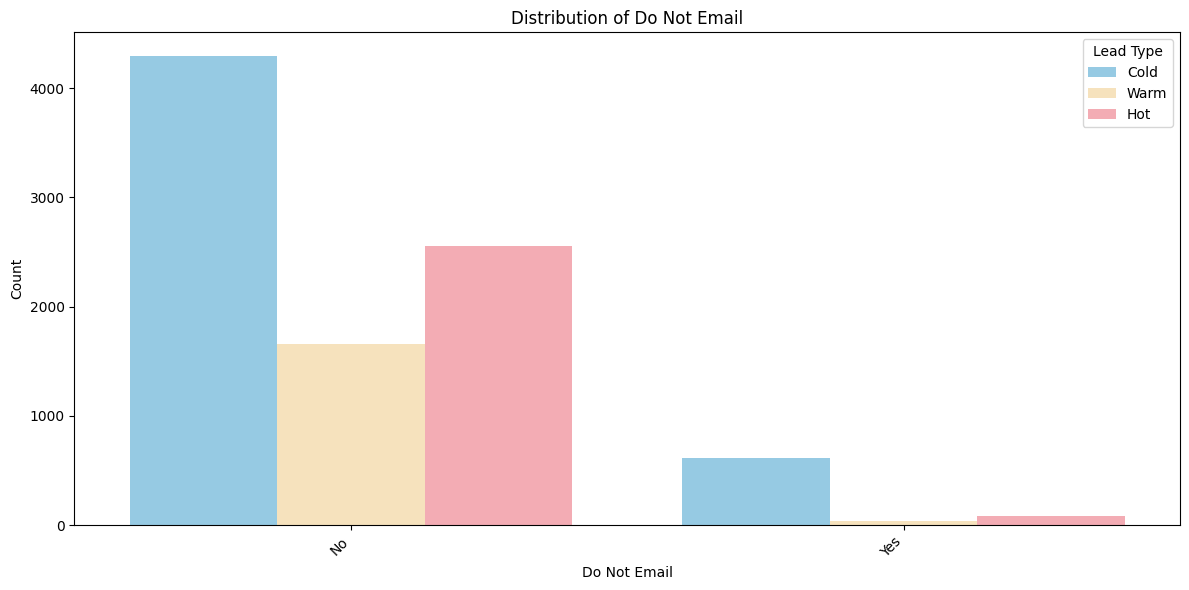

In [20]:
plot_categorical_distribution(df, column = 'Do Not Email', title = 'Distribution of Do Not Email')

### 5.7. `TotalVisits`

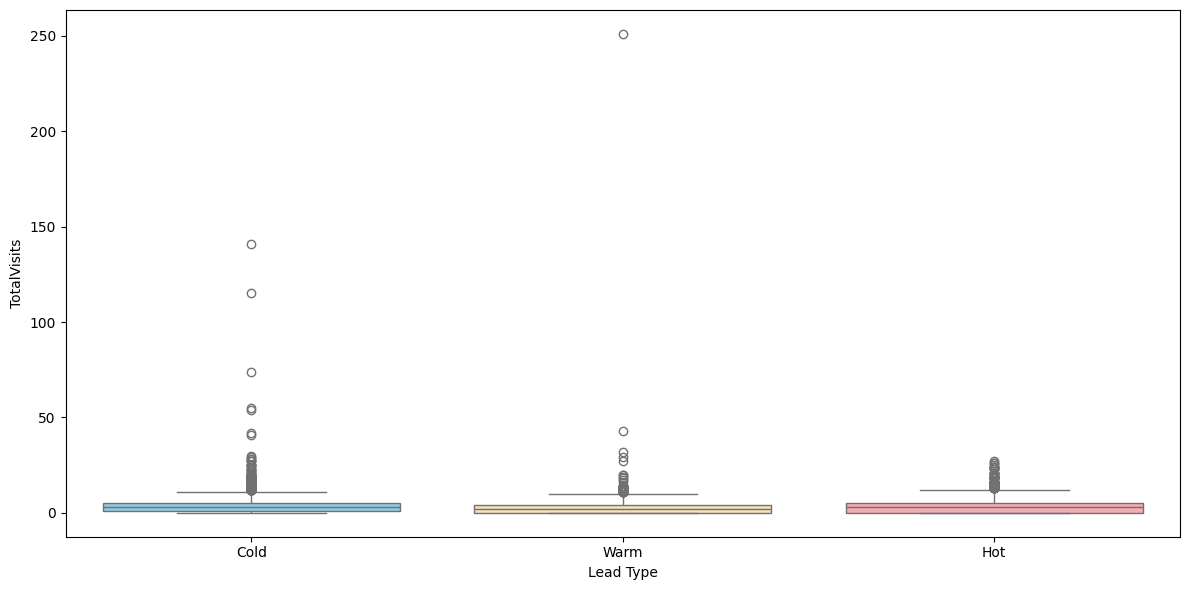

In [22]:
plot_numerical_distribution(df, column='TotalVisits')

### 5.8. `Total Time Spent on Website`

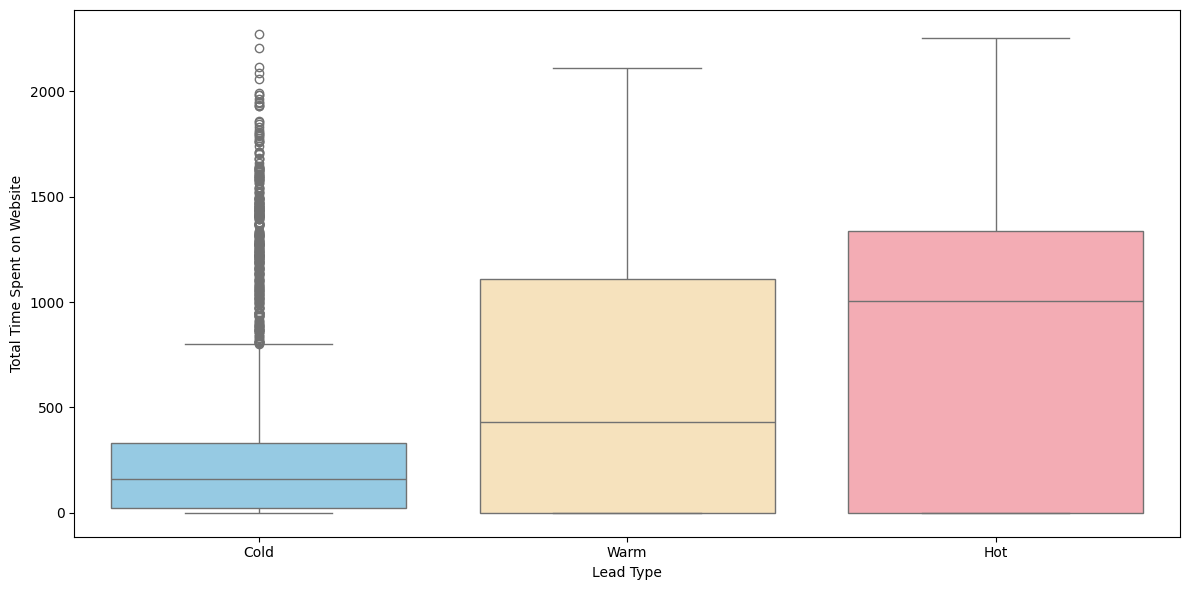

In [23]:
plot_numerical_distribution(df, column='Total Time Spent on Website')


### 5.8. `Page Views Per Visit`

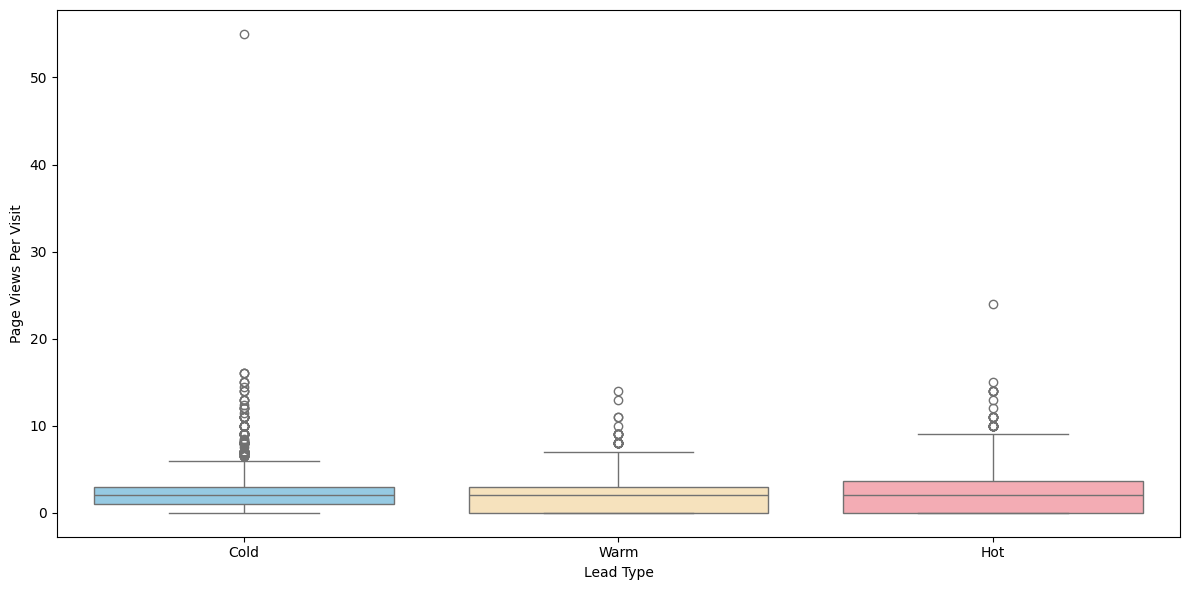

In [24]:
plot_numerical_distribution(df, column='Page Views Per Visit')